# Spectrum xAI

In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
from src.data.dataset import DAGMDataset
from src.models.models import DenseNetClassifier
from src.models.train_model import train_model
from src.models.evaluation import evaluate_model
from src.task.gradient_shap import show_gradient_shap
from src.task.scorecam import show_scorecam
from src.task.lime import show_lime
from src.task.saliency import show_saliency
from src.task.gradcam import show_gradcam
import sys 
sys.dont_write_bytecode = True

## Data Loading

In [2]:
CLASS = 1
IMAGE_PATH = f"data/dataset/Class{CLASS}/"

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = DAGMDataset(root_dir=IMAGE_PATH, split="Train", transform=transform)
test_dataset = DAGMDataset(root_dir=IMAGE_PATH, split="Test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 575
Test dataset size: 575


## Model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNetClassifier(pretrained=True, device=device)

criterion = torch.nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10

### Training

In [ ]:
train_accuracies, train_losses = train_model(model, train_loader, num_epochs, criterion, optimizer, device)
model.save_model(f"data/models/densenet121_class{CLASS}.pt")

### Evaluation

In [5]:
model.load_model(f"data/models/model_densenet121_class{CLASS}.pth")

In [6]:
test_accuracy = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 100.00%


### **Explanation**

In [118]:
index = 42
image, label, ground_truth = test_dataset[index][0].unsqueeze(0), test_dataset[index][1], test_dataset[index][2]

#### **Grad-CAM**

c:\Centrale Supelec\xAI\Spectrum\.venv\lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


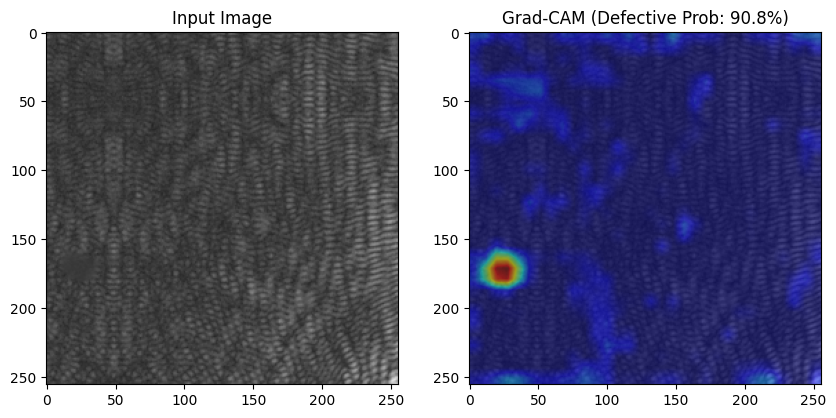

In [10]:
show_gradcam(model.model, image, 6, device)

#### **SHAP**

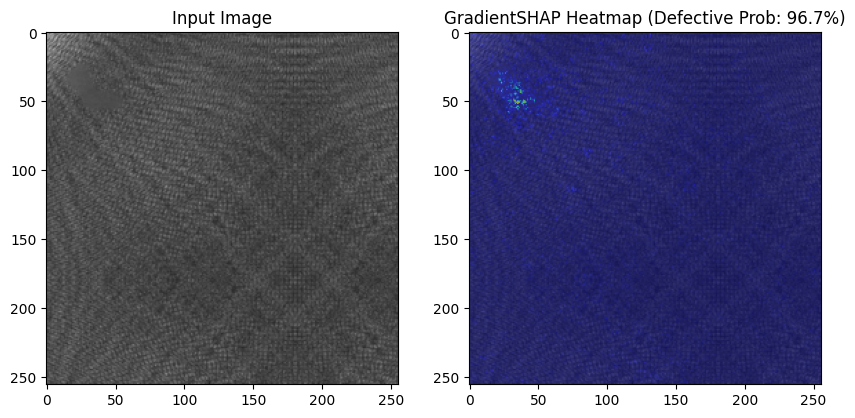

In [7]:
show_gradient_shap(model.model, image, device, num_samples=100)

#### **Score-CAM**

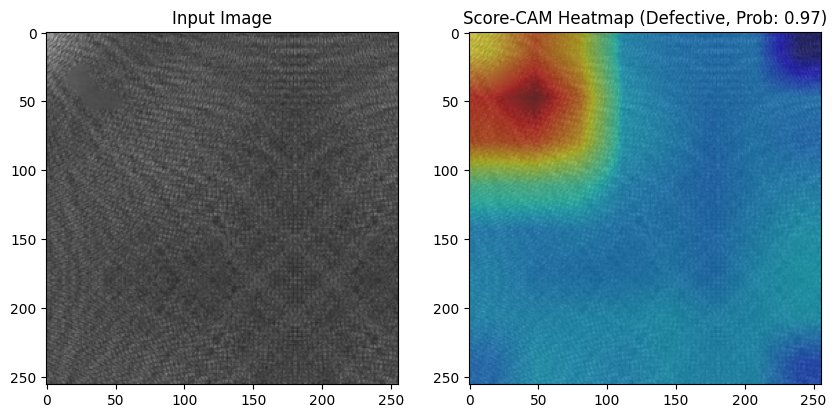

In [8]:
torch.cuda.empty_cache()
show_scorecam(model.model, image, -2, device)

#### **LIME**

In [ ]:
show_lime(model.model, image)

#### **Saliency**

In [94]:
def compute_Jaccard(heatmap, ground_truth):
    
    ground_truth = np.array(ground_truth[0].unsqueeze(0))
    heatmap = np.array(heatmap)
    
    intersection = np.logical_and(heatmap, ground_truth).sum() # pixels activated both in the heatmap AND the ground truth
    union = np.logical_or(heatmap, ground_truth).sum() # pixels activated wether in the heatmap OR the ground truth

    jaccard = round(intersection / union if union != 0 else 0, 2)

    return jaccard

In [95]:
def show_saliency(model, image, ground_truth, treshold):

    image.requires_grad = True

    output = model(image)

    model.zero_grad()  
    output.backward()

    saliency, _ = torch.max(image.grad.data.abs(), dim=1)

    saliency = saliency - saliency.min()
    saliency = saliency / saliency.max()
    
    saliency = saliency>treshold
    image = image.detach()
    
    _, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(image.cpu().squeeze().permute(1, 2, 0))
    ax[0].set_title("Input Image")
    ax[0].axis('off')

    ax[1].imshow(saliency.squeeze().cpu(), cmap='gray')
    ax[1].set_title('Heatmap activation')
    ax[1].axis('off')
    
    ax[2].imshow(ground_truth[0].cpu(), cmap='gray')
    ax[2].set_title('Ground Truth')
    ax[2].axis('off')

    print(compute_Jaccard(saliency, ground_truth))

    plt.show()

0.35


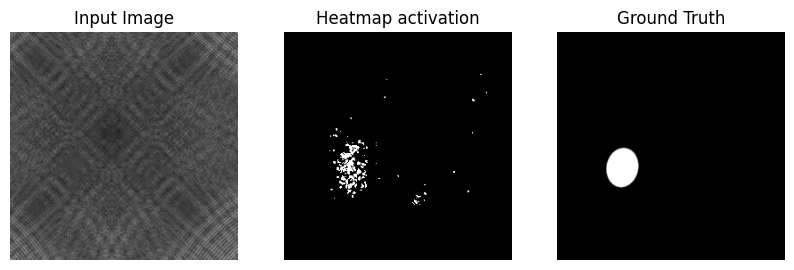

In [121]:
show_saliency(model.model, image, ground_truth, treshold=0.15)